# Content

This notebook contains:  

- Definition of individual_wells trap from the article [1]: 
https://doi.org/10.48550/arXiv.2211.07121  
- Optimization of DC voltage set of the trap, to match the required spectrum of secular frequencies with *Sion*.  
- Simulation of the ions in individual wells using *sion.polygon_trap()* function.  
- Calculation of normal modes of the resulting nonlinear crystal and secular frequencies spectrum with *Sion*.


In [1]:
from __future__ import division
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped)
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import warnings
import time
import sion as sn

#puts python plots inline with the code
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Defining the trap

The function, defining the trap from the [1] is written below. It plots the resulting trap on two plots: electrodes, with each electrodes of the different color, and RF-amplitude, demonstrated on 'bwr' colormap. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


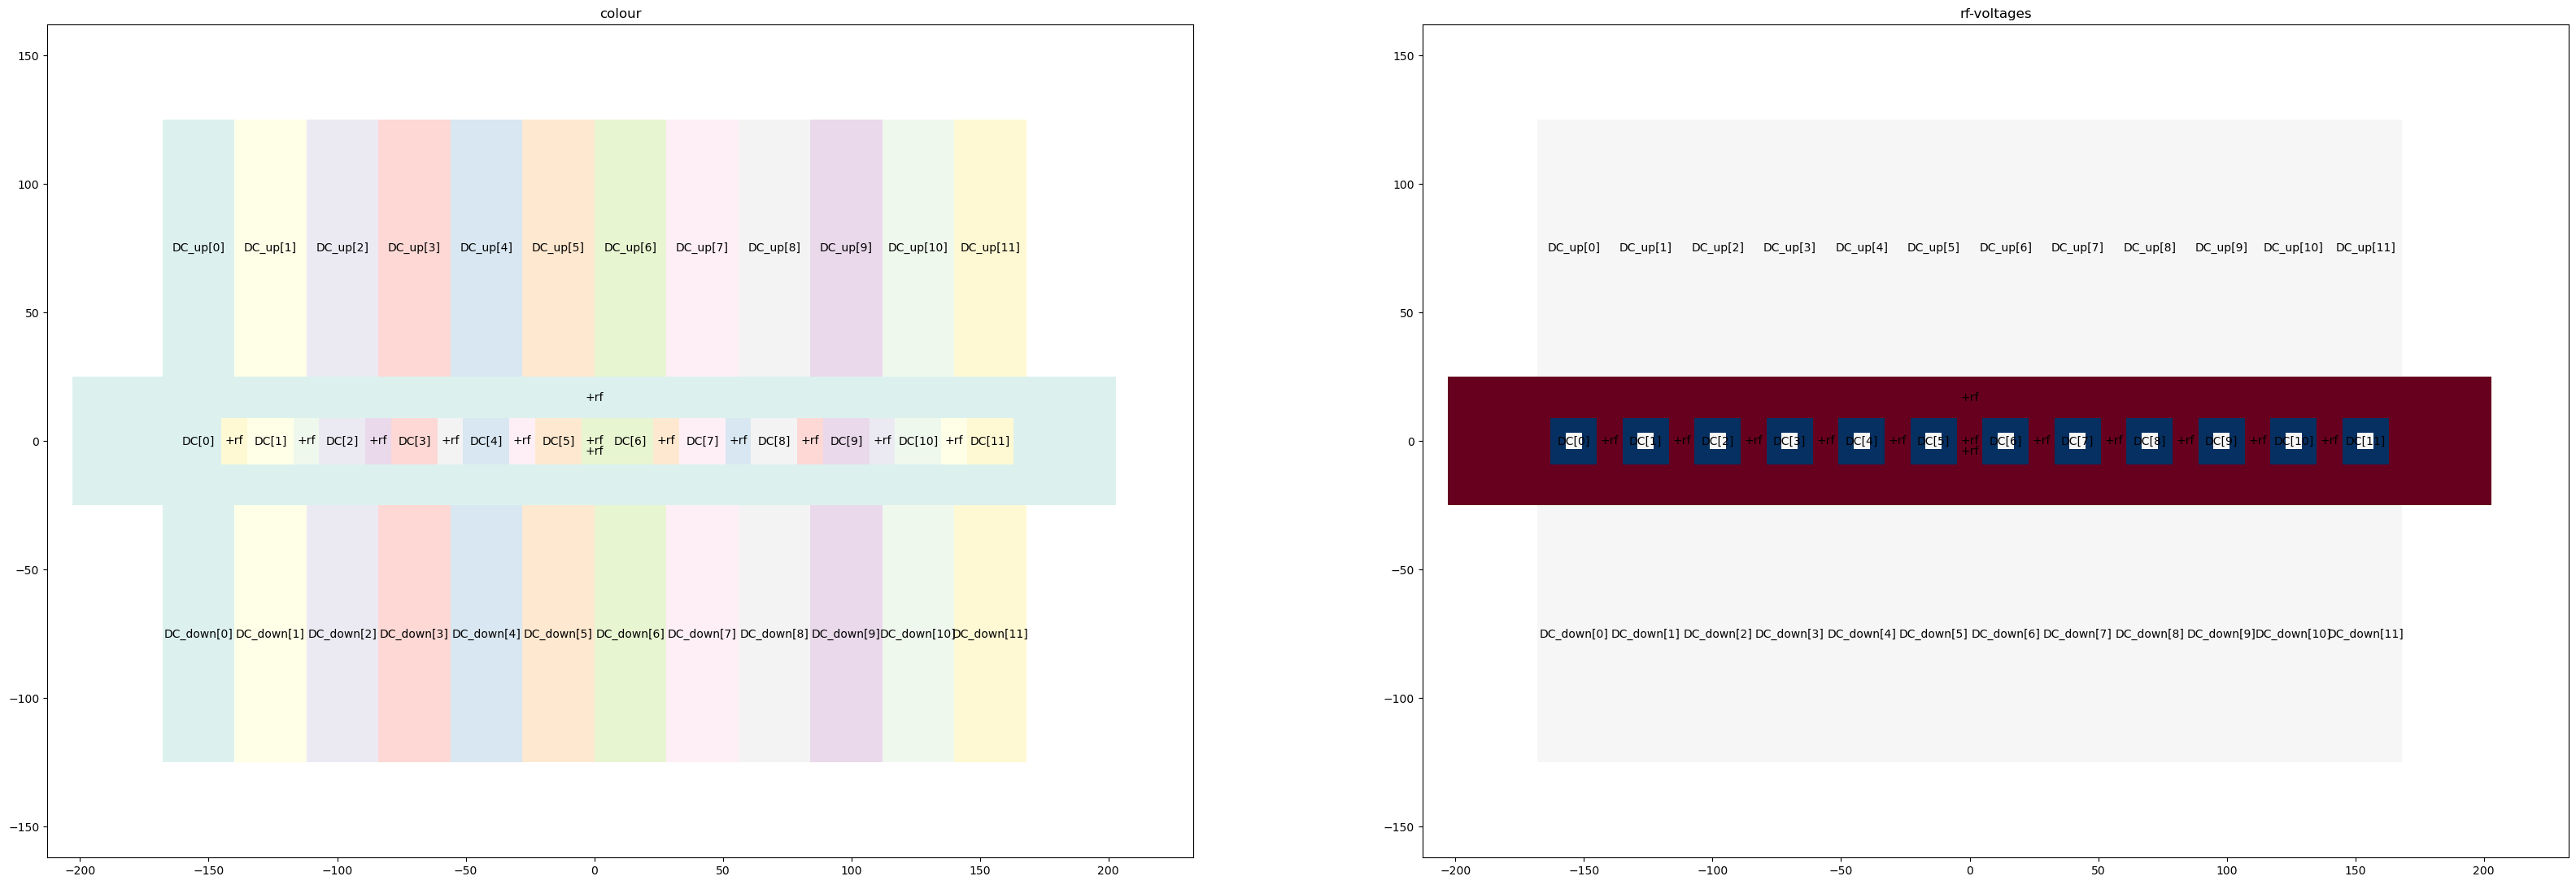

In [3]:
def array_trap(Urf, width, sq, n, inner_square, dc, side_dc, a, b, g, L, cheight=0, cmax=0):
    """
    Generates the trap from the article: https://doi.org/10.48550/arXiv.2211.07121
   
    
    Urf = [U+, U-]  rf amplitude of +rf and -rf squares
    width: float, width of +rf electrode borders
    sq: float, side of the inner square of rf+
    n: int, number of individual traps
    inner_square = [R_ex, r_in] external and inner sides of -rf square
    dc: float, side pf central DC square
    side_dc: height of side dc electrodes
    a: float, anisotropy: parameter, by which we multiply far left and
    far right width of +rf
    b: parameter, by which we multiply outer side width of rf+ electrode
    g: parameter, by which we multiply inner width of rf+ and rf-
    L: geomtry scale of the trap
    return: coordinates: list of coordinates to apply to polygon_trap()
    as [RF_coordinates, DC_coordinates]
            s: System object for electrode
    """
    dis = ((sq+width)*n+width)/2-(width+sq/2)
    rf_ex1 = [[-width*a-sq/2-dis, g*sq/2], [(n-0.5)*sq+(n-1+a)*width-dis, g*sq/2], [(
        n-0.5)*sq+(n-1+a)*width-dis, g*sq/2+b*width], [-a*width-sq/2-dis, g*sq/2+b*width]]
    rf_ex2 = [[-a*width-sq/2-dis, g*sq/2], [-a*width-sq/2-dis, -b*width-g*sq/2],
              [(n-0.5)*sq+(n-1+a)*width-dis, -g*sq/2-b*width], [(n-0.5)*sq+(n-1+a)*width-dis, g*sq/2], 
              [(n-0.5)*sq+n*width - 1*width-dis, g*sq/2], [(n-0.5)*sq + n*width - (1)*width - dis, -g*sq/2],
              [(n - 0.5)*sq + n*width - (n-1 + 1)*width - (n-1)*sq-sq-dis, -g*sq/2], [(n - 0.5)*sq + n*width - (n-1 + 1)*width - (n-1)*sq-sq-dis, g*sq/2] ]
    RF_coordinates = [np.array(rf_ex1)*L, np.array(rf_ex2)*L]
    
    rf_ex3 = []
    for i in range(n-1):
        rf_ex33 = [[(n - 0.5) * sq + n * width - (i + 2)
                      * width - (i+1) * sq-dis, g*sq / 2],
                      [(n - 0.5) * sq + n * width - (i + 2)
                      * width - (i+1) * sq-dis, -g*sq / 2],
                      [(n - 0.5) * sq + n * width - (i + 1)
                      * width - (i+1) * sq-dis, -g*sq / 2],[(n-0.5)*sq+n*width - (i+1)*width-(i+1)*sq-dis, g*sq/2]]
        rf_ex3.append([rf_ex33])
        RF_coordinates.append(np.array(rf_ex33)*L)

    electrodes = [
        ("+rf", [rf_ex1,
                 rf_ex2])]
    for i in range(n-1):
        # st = "-rf[" + str(i) +"]"
        electrodes.append(["+rf", rf_ex3[i]])

    R = inner_square[0]
    r = inner_square[1]

    rf_in = []
    for i in range(n):
        c = i*(sq+width)-dis
        top = np.array([[c - R/2, g*r/2], [c+R/2, g*r/2],
                       [c+R/2, g*R/2], [c-R/2, g*R/2]])
        bottom = np.array([[c-R/2, g*r/2], [c-R/2, -g*R/2], [c+R/2, -g*R/2], [c+R/2, g*r/2],
                          [c+r/2, g*r/2], [c+r/2, -g*r/2], [c-r/2, -g*r/2], [c-r/2, g*r/2]])
        rf_in.append([top, bottom])
        RF_coordinates.append(np.array(top)*L)
        RF_coordinates.append(np.array(bottom)*L)

    for i in range(n):
        # st = "-rf[" + str(i) +"]"
        electrodes.append(["", rf_in[i]])

    DC_coordinates = []

    dc_el = []
    for i in range(n):
        c = i * (sq + width)-dis
        elec = np.array([[c-dc/2, g*dc/2], [c-dc/2, -g*dc/2],
                        [c+dc/2, -g*dc/2], [c+dc/2, g*dc/2]])
        dc_el.append(np.array([elec]))
        DC_coordinates.append(np.array(elec)*L)

    dc_up = []
    dc_down = []
    for i in range(n):
        c = i * (sq + width) - dis
        elec_up = np.array([[c-dc/2-(R-r)/2-width/2, g*dc/2+g*(R-r)/2+b*width+side_dc], [c-dc/2-(R-r)/2-width/2, g*dc/2+g*(R-r)/2+b*width], [
                           c+dc/2+(R-r)/2+width/2, g*dc/2+g*(R-r)/2+b*width], [c+dc/2+(R-r)/2+width/2, g*dc/2+g*(R-r)/2+b*width+side_dc]])
        elec_down = np.array([[c - dc / 2 - (R - r) / 2 - width / 2, -(g*dc / 2 + g*(R - r) / 2 + b * width)],
                              [c - dc / 2 - (R - r) / 2 - width / 2, -
                               (g*dc / 2 + g*(R - r) / 2 + b * width+side_dc)],
                              [c + dc / 2 + (R - r) / 2 + width / 2, -
                               (g*dc / 2 + g*(R - r) / 2 + b * width+side_dc)],
                              [c + dc / 2 + (R - r) / 2 + width / 2, -(g*dc / 2 + g*(R - r) / 2 + b * width)]])
        dc_up.append(np.array([elec_up]))
        dc_down.append(np.array([elec_down]))
        DC_coordinates.append(np.array(elec_up)*L)
        DC_coordinates.append(np.array(elec_down)*L)

    for i in range(n):
        electrodes.append(["DC["+str(i)+"]", dc_el[i]])
        #coordinates.append(["DC[" + str(i) + "]", dc_el[i]*1e-6])
    for i in range(n):
        electrodes.append(["DC_up["+str(i)+"]", dc_up[i]])
    for i in range(n):
        electrodes.append(["DC_down["+str(i)+"]", dc_down[i]])

    # Polygon approach. All DCs are 0 for now
    s = System([PolygonPixelElectrode(cover_height=cheight, cover_nmax=cmax, name=f, paths=map(np.array, p))
                for f, p in electrodes])
    s["+rf"].rf = Urf[0]
    for i in range(n-1):
        # st = "-rf[" + str(i) +"]"
        s[i+1].rf = Urf[0]
    for i in range(n):
        # st = "-rf[" + str(i) +"]"
        s[i+n].rf = Urf[1]

    for i in range(n):
        st = "DC[" + str(i) + "]"
        s[st].dc = 0

    for i in range(n):
        st = "DC_up[" + str(i) + "]"
        s[st].dc = 0

    for i in range(n):
        st = "DC_down[" + str(i) + "]"
        s[st].dc = 0

    # creates a plot of electrode
    fig, ax = plt.subplots(1, 2, figsize=(40, 40))
    s.plot(ax[0])
    s.plot_voltages(ax[1], u=s.rfs)
    # u = s.rfs sets the voltage-type for the voltage plot to RF-voltages (DC are not shown)
    xmax = (n-0.5)*sq+((n-1)*width+width*a) * 1.2-dis
    ymaxp = (sq/2+(b+g)*width+side_dc)*1.2
    ymaxn = (sq/2+(b+g)*width+side_dc) * 1.2
    ax[0].set_title("colour")
    # ax[0] addresses the first plot in the subplots - set_title gives this plot a title
    ax[1].set_title("rf-voltages")
    for axi in ax.flat:
        axi.set_aspect("equal")
        axi.set_xlim(1.2*(-sq/2-a*width)-dis, xmax)
        axi.set_ylim(-ymaxn, ymaxp)
    plt.savefig('images/individual_wells_array_trap.eps')

    return s, RF_coordinates, DC_coordinates


# Global definition of trap parameters. Used for all cells in this notebook
L = 1e-6 # µm length scale
Vrf = 140. # RF peak voltage in V
M = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*200e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)
scale = Z/((L*Omega)**2*M)

U = [Urf, -1*Urf]
width = 10
sq = 18
n_squares = 12
inner_square = [18,6.4]
dc = 6.4
side_dc = 100
a = 4
b = 1.6
g = 1

dis = ((sq + width) * n_squares + width) / 2 - (width + sq / 2)

s, RF_electrodes, DC_electrodes = array_trap(U, width, sq, n_squares, inner_square , dc,side_dc, a,b,g,L, cheight = 100, cmax = 0)

# Optimization of voltage set

Following blocks determine DC voltage set to obtain the desired secular frequency spectrum. 

## Initial secular frequencies

On the plots after this block, the initial secular frequencies of ions in each individual well are presented for each principle axis of oscillation. They are calculated for grounded DC electrodes.

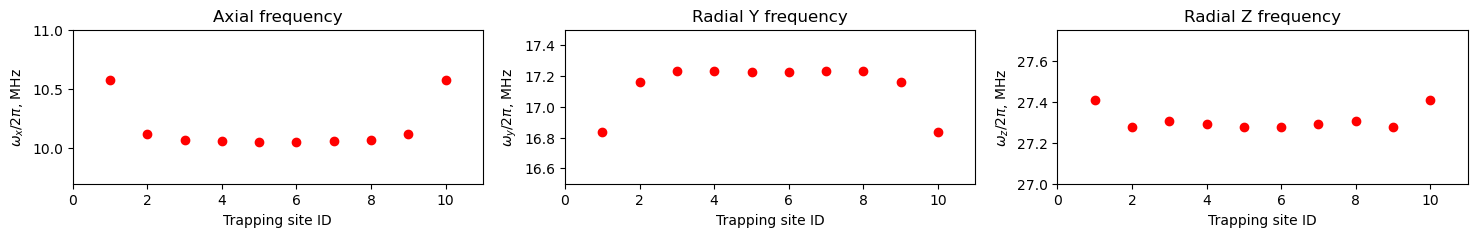

In [5]:
#determine all frequencies in minimums excluding 2 external traps
freqs_x = []
freqs_y = []
freqs_z = []
positions = []
cutoff = 1
# in trap there are 24 RF amplitudes, 36 DC voltages
u_set = np.zeros(24+36)

for i in range(cutoff, n_squares-cutoff):
    with s.with_voltages(dcs = u_set, rfs = None):
        #get potential well minimums
        x1 = s.minimum(np.array([(sq+width)*i-dis, 0, 20.4]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
        positions.append(x1)
        # Get trap frequencies
        curv_z, mod_dir=s.modes(x1,sorted=False)
        omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
        freqs_x.append(omega_sec[0])
        freqs_y.append(omega_sec[1])
        freqs_z.append(omega_sec[2])

fig, ax = plt.subplots(1, 3, figsize=(18, 2))
ax[0].plot(range(1,11), freqs_x, 'ro')
ax[0].set_title("Axial frequency")
ax[0].set_ylabel('$\omega_x/2\pi$, MHz')
ax[0].set_xlabel('Trapping site ID')
ax[0].set_xlim(0, 11)
ax[0].set_ylim(9.7, 11)

ax[1].plot(range(1,11), freqs_y, 'ro')
ax[1].set_title("Radial Y frequency")
ax[1].set_ylabel('$\omega_y/2\pi$, MHz')
ax[1].set_xlabel('Trapping site ID')
ax[1].set_xlim(0, 11)
ax[1].set_ylim(16.5, 17.5)

ax[2].plot(range(1,11), freqs_z, 'ro')
ax[2].set_title("Radial Z frequency")
ax[2].set_ylabel('$\omega_z/2\pi$, MHz')
ax[2].set_xlabel('Trapping site ID')
ax[2].set_xlim(0, 11)
ax[2].set_ylim(27, 27.75)
plt.savefig('images/unoptimized_sec_freqs.eps')
plt.show()

## Optimization routine

In the following block, the optimized voltage set is obtained with the *sion.voltage_optimization()* function.  
Optimization routine may take hours due to the complexity of functions.

In [14]:
dots = np.array(positions)

# determining the desired secular frequency spectrum
axis = [0, 1, 2]
# frequency in MHz/2pi
omeg_x = np.array([1,1,1,1,1,1,1,1,1,1])*10.1
omeg_y = np.array([1,1, 0.98, 0.98, 0.96, 0.96, 0.97, 0.97, 0.99, 0.99])*17.2
omeg_z = np.array([1, 0.98, 0.98, 0.96, 0.96, 0.97, 0.97, 0.99, 0.99, 1])*27.3
omegas = [omeg_x, omeg_y, omeg_z]

# optimization parameters
start_dcset = np.zeros(36)
learning_rate = 0.05
stoch = 12
eps = 1e-6

# executing optimization
start_time = time.time()

# First we will run stochastic descent to its expected convergence, then finish with the gradient descent
dcset_stoch = sn.voltage_optimization(s, Z, M, dots, axis, omegas, start_dcset, learning_rate, stoch = stoch, eps = eps, L = L, step = 100)

print('stoch optimization took %s minutes' %(-(start_time-time.time())//60))

learning_rate = 0.05
stoch = 0
eps = 1e-12
dcset = sn.voltage_optimization(s, Z, M, dots, axis, omegas, dcset_stoch, learning_rate, stoch = stoch, eps = eps, L = L, step = 50)

print('Optimization took %s minutes' %(-(start_time-time.time())//60))

Initial loss: 0.017368338220936003
Iteration: 100 Loss function: 0.002582237213843275
uset = [-0.18186535892935146, 0.3086297755887128, 0.12336504013919328, 0.23768785531614192, 0.26522704393708135, 0.41240130352140825, 0.2714792905154906, 0.2559862080936791, 0.14879164498137168, 0.14315027320263002, 0.2882491880748767, -0.1722317517613539, 0.728410699916234, 0.17402896434459883, -0.09844140704337992, -0.33471835018449936, -0.12557740623419197, -0.24415854613505103, -0.1973006755039033, -0.14099595148828872, -0.22931132381144967, -0.1842338998334057, 0.2909363401736274, 0.6042470430756928, 0.8389206257418972, 0.20886479340062425, -0.18883209775932758, -0.3491575775027384, -0.1535160561360332, -0.21324458825846804, -0.19964158206001842, -0.22997159537801443, -0.18446975306243624, -0.17981406194817753, 0.30786904333321696, 0.49003559949683934] 

Iteration: 200 Loss function: 0.0017858069655637813
uset = [-0.24459692078816966, 0.5586240771585583, 0.3404435105498685, 0.3392896608126828, 0.

## Resulting secular frequency spectrum

This block shows plots of the resulting secular frequency spectrum and DC voltage distribution

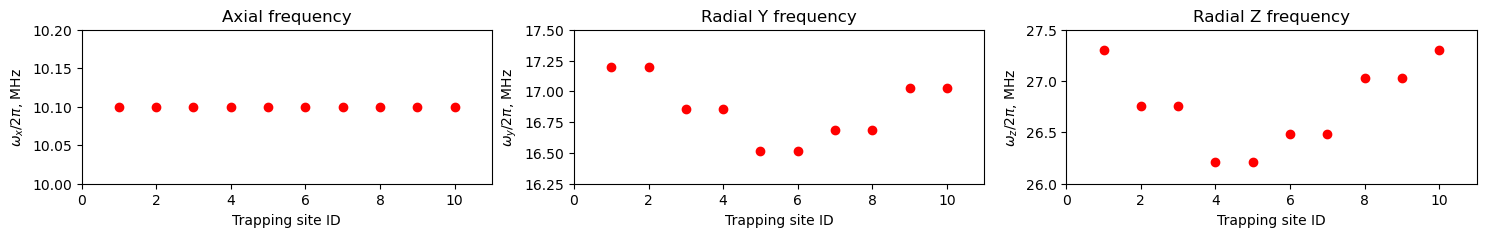

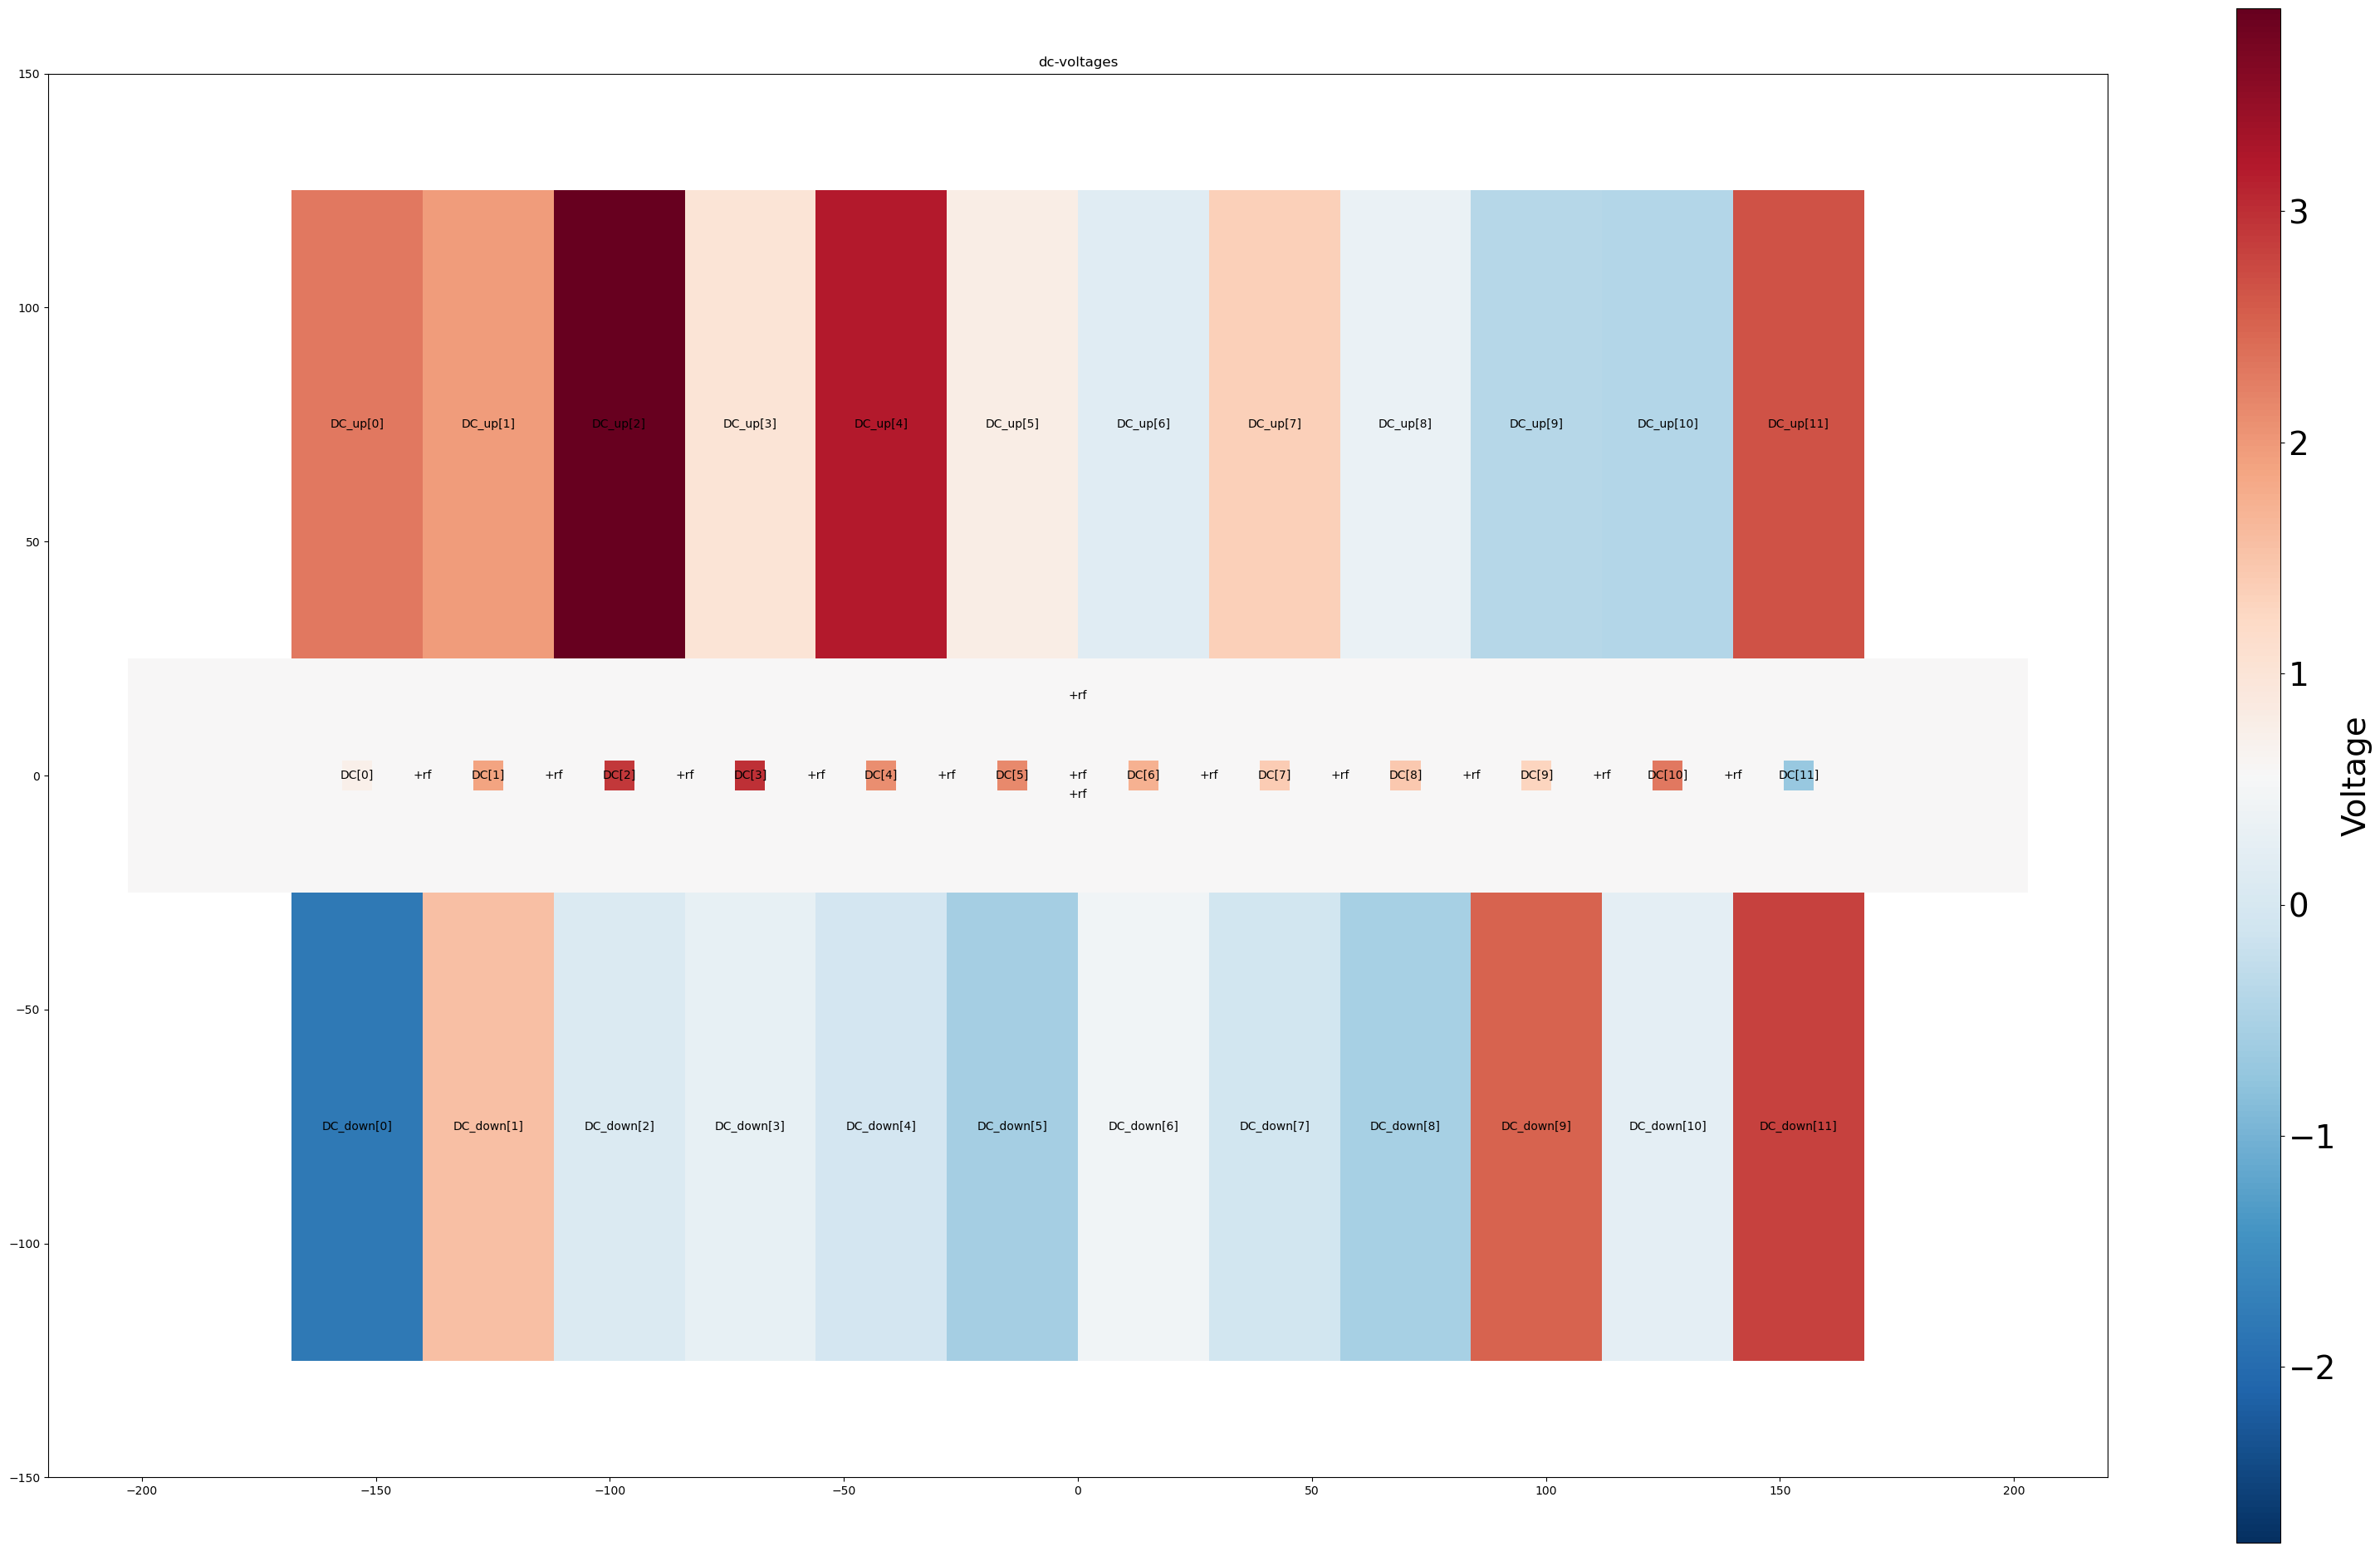

In [14]:
#repeating last iteration
uset = [0.21651786829832492, 1.5704780293472387, 2.745172844346861, 2.842318105449554, 1.8132089023255713, 1.8521594200157314, 1.3832627259468304, 0.9849142625141372, 1.0538706042180417, 0.8723468305305059, 2.0493220271321655, -1.455200299617975, 2.0380467466495653, 1.6532768067243495, 3.8783249513860483, 0.5231983978812477, 3.071424875082992, 0.28529116100447177, -0.4814840859344738, 0.9107566044482895, -0.2460738324295731, -1.1056560403841764, -1.1337148263403973, 2.4641900551910325, -2.7604550410896995, 1.175534416170778, -0.5559985703637881, -0.3061001212956751, -0.7255733964762806, -1.330553009904256, -0.14982879428646334, -0.7367441594703434, -1.273005760754428, 2.28941483151913, -0.3700470128099083, 2.6580652449161404] 

uset = np.array(uset)

freqs_x = []
freqs_y = []
freqs_z = []
positions = []
cutoff = 1
u_set = np.append(np.zeros(24), uset)
sq = 18
width = 10
omegas = []

for i in range(cutoff, n_squares-cutoff):
    with s.with_voltages(dcs = u_set, rfs = None):
        #get potential well minimums
        x1 = s.minimum(np.array([(sq+width)*i-dis, 0, 20.5]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
        positions.append(x1)
        # Get trap frequencies
        curv_z, mod_dir=s.modes(x1,sorted=False)
        omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
        freqs_x.append(omega_sec[0])
        freqs_y.append(omega_sec[1])
        freqs_z.append(omega_sec[2])
        omegas.append(list(omega_sec*1e6))

fig, ax = plt.subplots(1, 3, figsize=(18, 2))
ax[0].plot(range(1,11), freqs_x, 'ro')
ax[0].set_title("Axial frequency")
ax[0].set_ylabel('$\omega_x/2\pi$, MHz')
ax[0].set_xlabel('Trapping site ID')
ax[0].set_xlim(0, 11)
ax[0].set_ylim(10, 10.2)

ax[1].plot(range(1,11), freqs_y, 'ro')
ax[1].set_title("Radial Y frequency")
ax[1].set_ylabel('$\omega_y/2\pi$, MHz')
ax[1].set_xlabel('Trapping site ID')
ax[1].set_xlim(0, 11)
ax[1].set_ylim(16.25, 17.5)

ax[2].plot(range(1,11), freqs_z, 'ro')
ax[2].set_title("Radial Z frequency")
ax[2].set_ylabel('$\omega_z/2\pi$, MHz')
ax[2].set_xlabel('Trapping site ID')
ax[2].set_xlim(0, 11)
ax[2].set_ylim(26, 27.5)
plt.savefig('images/optimized_sec_freqs.eps')

plt.show()

with s.with_voltages(dcs = u_set):    
    
    fig, ax = plt.subplots(1,1, figsize=(40, 40))
    s.plot_voltages(ax, u=s.dcs)
    #u = s.dcs sets the voltage-type for the voltage plot to DC-voltages (RF are not shown)
    xmax = 220
    ymaxn = 150
    ymaxp = 150
    ax.set_title("dc-voltages")
    ax.set_aspect('equal')
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-ymaxn, ymaxp)
    #Add colorbar
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(u_set), vmax=np.max(u_set))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, shrink = 0.6, aspect = 35)
    
    """cb = plt.colorbar(ax=ax[2], shrink=0.9)"""
    cb.ax.tick_params(labelsize=28)
    cb.set_label('Voltage', fontsize = 28)
    plt.savefig('images/array_dc_trap.eps')

# Simulation

These blocks contain the simulation of ions in the trap by *sion.polygon_trap()* function.

## Potential

Potential of the trap, calculated with *electrode* package. It demonstrates indvidual wells and potential minimums in each well. If the simulation is correct, the final ion positions will coincide with the minimum coordinates.

RF pseudopotential minimum: 0.02185 eV at (14.5, -1.01, 20.5)µm
secular frequencies: (10.1, 16.51, 26.48) MHz
in directions
a: [ 0.99934124 -0.03551522  0.00746702] 
b: [0.03485867 0.99659029 0.07478407] 
c: [-0.01009754 -0.07447452  0.99717179]


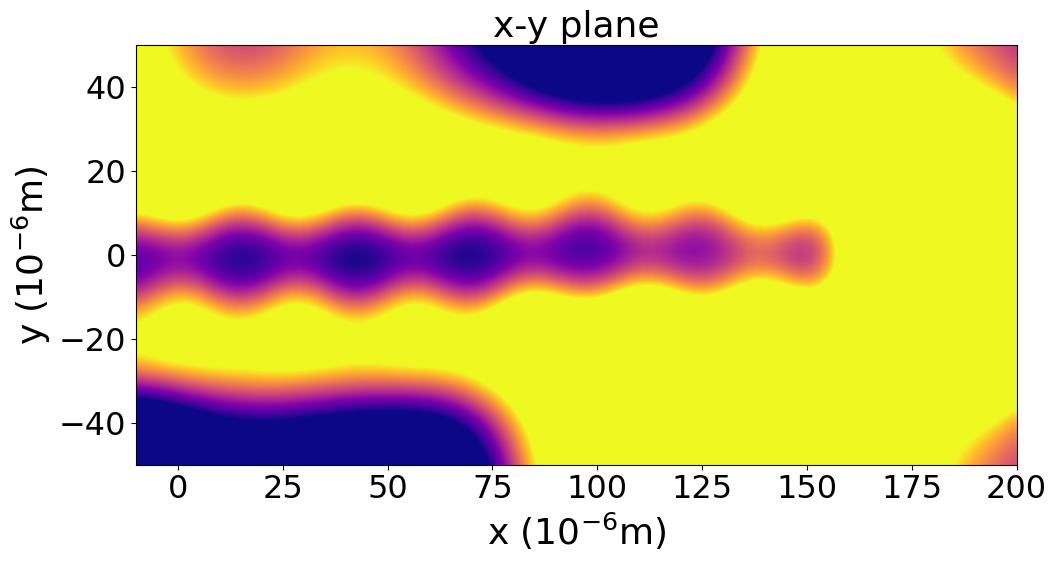

In [16]:
with s.with_voltages(dcs = u_set, rfs = None):
    x_ini = [14.27643,  0.60607, 20.50245]
    x0 = s.minimum(x_ini, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    p_tot0=s.potential(x0, 0)[0]
    print("RF pseudopotential minimum: %.4g" % p_tot0,"eV at (%.3g, %.3g, %.3g)µm" % (x0[0], x0[1], x0[2]))

    curv_z, mod_dir=s.modes(x0,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    # in with_voltages, all electrodes have to be listed in an array
    # (the array for dcs also contains the RF electrode)

    # 2D plot settings

    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -10, 200 #set the plot ranges
    ymin, ymax = -50, 50
    zmin, zmax = 0, 50
    x_cut, y_cut, z_cut = x0[0], x0[1], x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(0.003,0.4, 0.005)# set the range for contour lines (range in eV)
    v_min, v_max = 0., 0.4 #set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    fig = plt.figure()
    fig.set_size_inches(25,12)

    # x-y cross section
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax1.set_title("x-y plane" ,fontsize=fs)
    ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
    ax1.tick_params(axis='x', labelsize=ls)
    ax1.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
    pot = shaped(s.potential)(xyz)
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    #CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
    im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
    im.set_interpolation('bilinear')


## Simulation of ion motion

These blocks show the results of the simulation of an ion crystal in this trap. Each ion is placed in the respective individual well.

In [17]:
def min_positions(minim, n_squares):
    positions = []
    for i in range(1,n_squares-1):
        positions.append([(i*(sq+width)-dis)*L, 0, minim])
        
    return positions

positions = min_positions(20e-6, n_squares)

name = Path('individual_wells_voltage_optimization.ipynb').stem

sim = pl.Simulation(name)
#
Caions = {'mass': 40, 'charge': 1}
Beions = {'mass': 9, 'charge': 1}

rf_set_plus = np.array([Vrf for i in range(13)])
rf_set_minus = np.array([-Vrf for i in range(24)])
rf_set = np.concatenate([rf_set_plus, rf_set_minus])

dc_set = np.zeros(len(uset))

Omegas = [Omega for i in range(37)]

sim.append(pl.placeions(Caions, positions))

sim.append(sn.polygon_trap(Omegas, rf_set, dc_set, RF_electrodes, DC_electrodes))


sim.append(pl.langevinbath(0, 1e-7))

sim.append(pl.dump('logs\posvol.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(4e4))
try:
    sim.execute()
except:
    pass

Reducing timestep to 3.978873577297384e-11 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  10 settings made for charge
10 atoms in group 1
10 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  T

C:\Users\User_A\anaconda3\Lib\site-packages\pylion-0.5.2-py3.11.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


## Plots of ion trajectory

This block demonstrate the plot of an ion trajectory in the trap during the simulation.

C:\Users\User_A\AppData\Local\Temp\ipykernel_19112\261837085.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


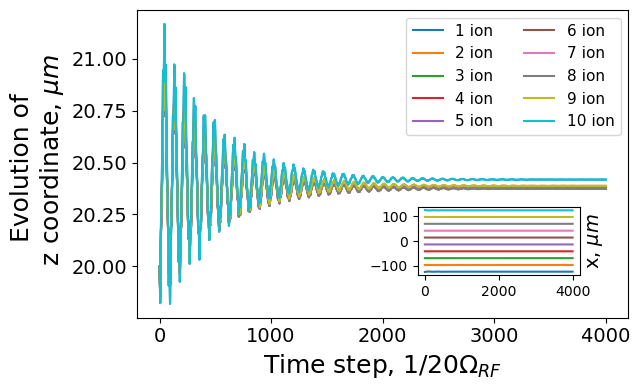

In [15]:
#import data
_, data = pl.readdump('logs\posvol.txt')
data *=1e6

#plotting routine
fig, ax = plt.subplots(1,1,figsize = [6.5, 4] )
for n in range(n_squares-2):
    st = str(n+1)
    ax.plot(data[:, n, 2], label = st + ' ion')
plt.locator_params(axis='x', nbins=5)
ax.legend(prop = {'size': 11}, ncol = 2)
ax.tick_params(axis='both', which='major', labelsize=14)
left, bottom, width, height = [0.65, 0.3, 0.25, 0.17]
ax2 = fig.add_axes([left, bottom, width, height])
for n in range(n_squares-2):
    ax2.plot(data[:, n, 0])
ax2.set_ylabel('x, $\mu m$', fontsize = 14)
ax2.yaxis.set_label_position("right")
ax.set_ylabel('Evolution of \n z coordinate, $\mu m$', fontsize = 18)
ax.set_xlabel('Time step, $1/20\Omega_{RF}$', fontsize = 18)
plt.tight_layout()
plt.savefig('images/array_trap_evolution.eps')
plt.show()

# Calculation of normal modes 

In this block, the normal modes of this crystal in the presented voltage configuration is demonstrated. The normal mode spectrum is associated with the Fig. 5 from the [1]. On the plots, the normal mode interaction matrices in all 3 axes are demonstrated.

Axial freqs: [10100012. 10100106. 10100291. 10100527. 10100775. 10101022. 10101246.
 10101422. 10101553. 10101634.]
Radial freqs y: [16511587. 16511830. 16683579. 16683822. 16855599. 16855838. 17027606.
 17027916. 17199655. 17199933.]
Radial freqs z: [26207734. 26207894. 26480603. 26480840. 26753729. 26753897. 27026645.
 27026855. 27299910. 27299935.]
X Normal Vectors:
 [[-0.334 -0.341 -0.339 -0.337 -0.328 -0.318 -0.3   -0.294 -0.275 -0.286]
 [ 0.423  0.381  0.292  0.176  0.041 -0.097 -0.222 -0.335 -0.402 -0.476]
 [ 0.434  0.264 -0.005 -0.263 -0.415 -0.413 -0.25  -0.003  0.251  0.452]
 [-0.401 -0.061  0.319  0.435  0.193 -0.201 -0.429 -0.337  0.043  0.409]
 [ 0.364 -0.15  -0.442 -0.129  0.362  0.371 -0.119 -0.454 -0.157  0.346]
 [ 0.326 -0.344 -0.304  0.347  0.305 -0.337 -0.309  0.309  0.298 -0.274]
 [-0.255  0.434 -0.047 -0.41   0.312  0.217 -0.447  0.03   0.417 -0.242]
 [-0.192  0.433 -0.349 -0.019  0.372 -0.419  0.128  0.278 -0.453  0.2  ]
 [ 0.129 -0.348  0.46  -0.404  0.209  0.064

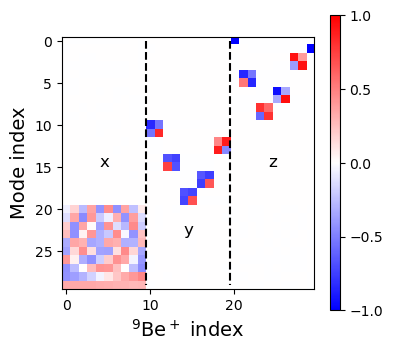

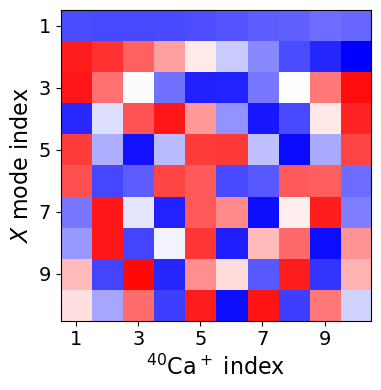

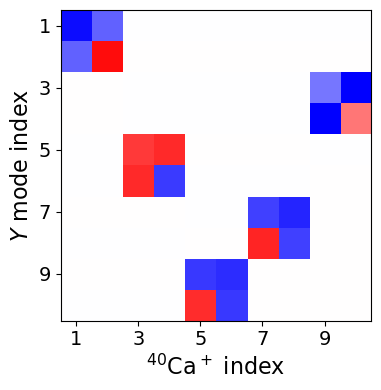

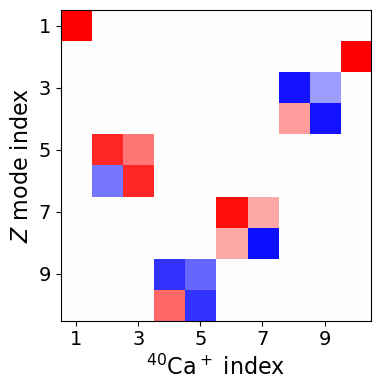

In [16]:
omegas = np.array(omegas)
    

ion_number = 10
ion_masses = [M for el in range(ion_number)]

_, data = pl.readdump('logs/posvol.txt')


final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]
sort = np.argsort(final_x)

ion_positions = np.zeros([ion_number, 3])

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

equilibrium_positions = []
for i in range(ion_number):
    equilibrium_positions.append(np.array([np.mean(data[3800:, i, 0]), np.mean(data[3800:, i, 1]), np.mean(data[3800:, i, 2])]))
equilibrium_positions = np.array(equilibrium_positions)

freqs, modes = sn.normal_modes(equilibrium_positions, omegas, ion_masses, linear = True)

axial_freqs = freqs[0]
radial_freqs_y = freqs[1]
radial_freqs_z = freqs[2]
axial_modes = modes[0]
radial_modes_y = modes[1]
radial_modes_z = modes[2]

np.set_printoptions(0, suppress = True)
print('Axial freqs:', axial_freqs)
print('Radial freqs y:', radial_freqs_y)
print('Radial freqs z:', radial_freqs_z)

np.set_printoptions(3, suppress = True)
print('X Normal Vectors:\n', axial_modes)

print('Y Normal Vectors:\n', radial_modes_y)

print('Z Normal Vectors:\n', radial_modes_z)

freqs, modes = sn.normal_modes(ion_positions, omegas, ion_masses, linear = False)

plt.figure(figsize = [4,4])
plt.imshow(modes[::-1,:] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
plt.colorbar(shrink = 0.8, aspect = 30, ticks = [-1, -0.5, 0, 0.5, 1])
plt.tight_layout()
plt.vlines([9.5,19.5], ymin = 0, ymax = 29 ,linestyles = 'dashed', color = 'k')
plt.locator_params(axis='x', nbins=3)
plt.text(4, 15,'x', fontsize = 'large')
plt.text(14,23,'y',fontsize = 'large')
plt.text(24, 15,'z',fontsize = 'large')
plt.xlabel('$^{9}$Be$^+$ index', fontsize = 14)
plt.ylabel('Mode index', fontsize = 14)
plt.tight_layout()
plt.savefig('images/individual_wells_example_modes.eps', format = 'eps')
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(axial_modes[:] / np.max(np.abs(axial_modes[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$X$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(radial_modes_y[::-1,:] / np.max(np.abs(radial_modes_y[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$Y$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize = [4,4]) 
plt.imshow(radial_modes_z[::-1,:] / np.max(np.abs(radial_modes_z[:])), cmap='bwr',vmin = -1, vmax = 1)
plt.xlabel('$^{40}$Ca$^+$ index', fontsize = 16)
plt.ylabel('$Z$ mode index', fontsize = 16)
plt.xticks([0,2,4,6,8], [1,3,5,7,9])
plt.yticks([0,2,4,6,8], [1,3,5,7,9])
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

Mode index: 1, Frequency: 10100012 Hz
Vector: [-0.33423, -0.34112, -0.33924, -0.33729, -0.3281, -0.31802, -0.30035, -0.29403, -0.27514, -0.28623, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0]
Mode index: 2, Frequency: 10100106 Hz
Vector: [0.4225, 0.38089, 0.29161, 0.17567, 0.04071, -0.09686, -0.22168, -0.33464, -0.40191, -0.47626, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0]
Mode index: 3, Frequency: 10100291 Hz
Vector: [0.43444, 0.26438, -0.00475, -0.2635, -0.41498, -0.41254, -0.2497, -0.00321, 0.251, 0.45183, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0]
Mode index: 4, Frequency: 10100527 Hz
Vector: [-0.40133, -0.06119, 0.31932, 0.43463, 0.19273, -0.20077, -0.42931, -0.33728, 0.04314, 0.40859, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]

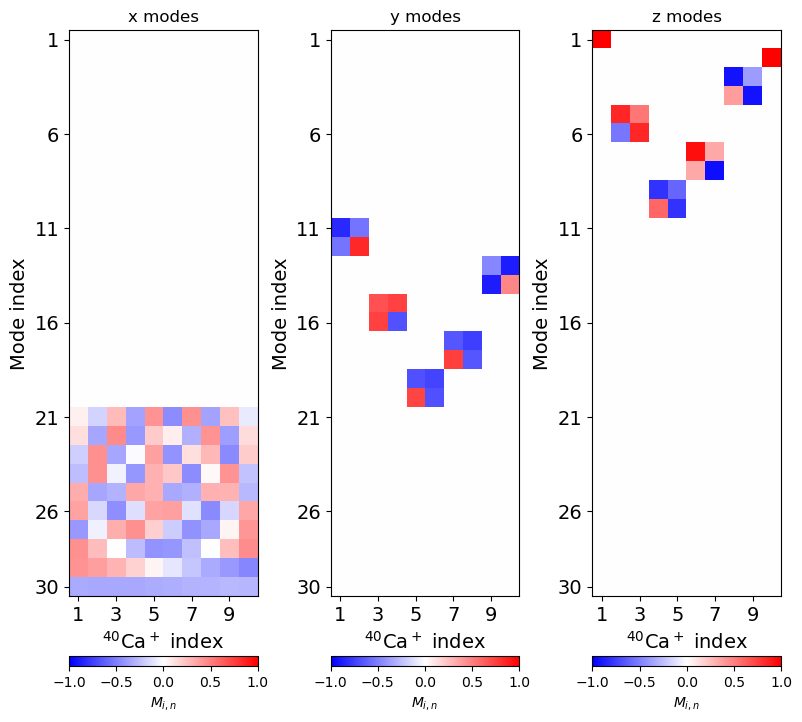

In [22]:
freqs, modes = sn.normal_modes(equilibrium_positions, omegas, ion_masses)
for i, mode in enumerate(modes):
    print(f'Mode index: {i+1}, Frequency: {int(np.round(freqs[i], 0))} Hz')
    print(f'Vector: {list(np.round(mode, 5))}')

fig, ax = plt.subplots(1, 3, figsize = [8, 8])
ax[0].set_title('x modes')
ax[1].set_title('y modes')
ax[2].set_title('z modes')
for i in range(3):
    im = ax[i].imshow(modes[::-1,i*ion_number:(i+1)*ion_number] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
    ax[i].set_xlabel('$^{40}$Ca$^+$ index', fontsize = 14)
    ax[i].set_ylabel('Mode index', fontsize = 14)
    ax[i].set_xticks([0, 2, 4, 6, 8],[1, 3, 5, 7, 9],fontsize = 14)
    ax[i].set_yticks([0, 5, 10, 15, 20, 25, 29],[1, 6, 11, 16, 21, 26, 30], fontsize = 14)
    cb = fig.colorbar(im, ax=ax[i], orientation='horizontal', shrink = 1, pad = 0.08)
    cb.set_label('$M_{i,n}$')
    
plt.tight_layout()
plt.savefig('images/ind_wells_norm_modes.eps')
plt.show()